<a href="https://colab.research.google.com/github/chakradhar915/Chakradhar_INFO5502_Spring2022/blob/main/lab_assignment_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The sixth Lab-assignment (03/24/2022, 50 points in total)

The purpose of this exercise is to build a simple predicition model which can helpyou understand the workflow of machine learning. 

### Task Decription 

The goal of this assignment is to predict bike share use, given the hour, day, and information about the weather. Companies like Divvy try to predict how much demand there will be for bikes on any given day to allocate resources to redistribute bikes so that, ideally, very few bike stations are ever full (when you can’t park your bike) or empty (when you can’t pick up a bike if you want to).

The data (link: https://github.com/unt-iialab/info5502-spring2022/tree/main/datasets/lab_assignment_06) in Github provides detailed information on the data set and necessary downloads.

### Data Description

You are provided hourly rental data spanning two years (link: https://github.com/unt-iialab/info5502-spring2022/tree/main/datasets/lab_assignment_06). For this task, the training set is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or its components "casual" and "registered".

Data Fields

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1 - Clear, Few clouds, Partly cloudy, Partly cloudy

2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Output

Submission Format

Your output (a separate file) must have a header line and should be structured in the following format:

 datetime,count
 
 2011-01-20 00:00:00,0 
 
 2011-01-20 01:00:00,0
 
 2011-01-20 02:00:00,0
 
 ...
 
The tutorial code should demonstrate how to generate such a file from a very simple prediction model. Note, these prediction are to be done on the test file under the data tab, where you do not know the actual count, and should match the rows of the test file in count and order.

Your predictions should be compared to the ground truth information (sample_prediction.csv). Score are calculated using Root Mean Squared Error (RMSE).

### Tips

●	Add features: Pick columns/features from the data you already have. Or make a new feature from the ones you have. For example, the tutorial makes ‘hour’ from the datetime stamp, which seemed very useful. How about ‘month’?

●	Model selection: Try different models. Make sure they are regression models rather than classification models. Tip: random forest regression is a good, all around modeling strategy on complicated data sets.

●	Model tuning: Almost all regression models have parameters to tune (“hyperparameters”). E.g. polynomial regression has the degree of the polynomial (n = 1 for a line, n=2 for a quadratic fit, n=3 for a cubic fit…). Generally, one extreme makes the model too simple (e.g. a line for a curved set of points) and the other extreme makes the model overfit/be too complex, and usually the right choice is in between. For some models it is obvious what to tune (e.g. k for k nearest neighbors regression) and some don’t need much tuning with defaults that often work well. e.g. try changing the number of trees used in the random forest model!

●	Cross validation: The tutorial has a simple way of separating training and test data, however, there are better ways of splitting training and test data. Look into cross validation techniques, which are more reliable than an arbitrary split of training and test data.

●	Separate models for ...: Notice that count comes from just adding casual riders and registered riders. However, what if these two types of riders acted very differently? It might make sense to make two separate models and just add the results of both models together. This is also true for any subsets of your data that may behave wildly differently (e.g. create a separate model for each season?)

### Your code

In [63]:
import pandas as pd
import numpy as np
import csv as csv
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

In [155]:
#Reading the data
bike_df = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/datasets/lab_assignment_06/train_luc.csv", sep=",")

print("\nNumber of samples:",bike_df.shape[0],"and number of features:",bike_df.shape[1],"\n")

bike_df


Number of samples: 9174 and number of features: 12 



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9169,2012-12-16 19:00:00,4,0,0,1,14.76,17.425,93,8.9981,10,99,109
9170,2012-12-16 20:00:00,4,0,0,2,15.58,19.695,82,0.0000,14,108,122
9171,2012-12-16 21:00:00,4,0,0,2,14.76,18.940,93,0.0000,14,92,106
9172,2012-12-16 22:00:00,4,0,0,2,16.40,20.455,82,12.9980,6,83,89


In [156]:
def hour_of_day(dt):
    return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").time().hour
bike_df['hour'] = bike_df['datetime'].map(hour_of_day)
def month(dt):
    return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").month
    #return month.month
bike_df['month'] = bike_df['datetime'].map(month)
bike_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9169,2012-12-16 19:00:00,4,0,0,1,14.76,17.425,93,8.9981,10,99,109,19,12
9170,2012-12-16 20:00:00,4,0,0,2,15.58,19.695,82,0.0000,14,108,122,20,12
9171,2012-12-16 21:00:00,4,0,0,2,14.76,18.940,93,0.0000,14,92,106,21,12
9172,2012-12-16 22:00:00,4,0,0,2,16.40,20.455,82,12.9980,6,83,89,22,12


In [157]:
bike_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
mean,2.505559,0.031284,0.678875,1.414868,20.130401,23.578433,61.715064,12.737931,35.713647,154.868106,190.581753,11.537933,6.517114
std,1.116618,0.174094,0.466934,0.635363,7.940504,8.617957,19.401829,8.199027,49.667738,150.981155,181.011530,6.915338,3.447047
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,35.000000,41.000000,6.000000,4.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,61.000000,11.001400,16.000000,117.000000,144.000000,12.000000,7.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,48.000000,222.000000,282.000000,18.000000,10.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000,23.000000,12.000000


In [158]:
# pick your features
from sklearn import preprocessing
cols = ['hour','month','atemp','holiday','workingday','humidity']# clearly a simple model
X = bike_df[cols]

y = bike_df['count'].values

#dropping the date time because no need to train as we are using the hour and month
bike_df = bike_df.drop("datetime", axis=1)

In [159]:
from sklearn.datasets import load_boston
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
#split the data into test and train by using the train_test_split
train_set_x,test_set_x,train_set_y,test_set_y = train_test_split(bike_df,y, test_size = 0.3, random_state = 10)
print("train set X shape",train_set_x.shape)
print("test set X shape",test_set_x.shape)
print("train set Y shape",train_set_y.shape)
print("test set Y shape",test_set_y.shape)
train_set_x

train set X shape (6421, 13)
test set X shape (2753, 13)
train set Y shape (6421,)
test set Y shape (2753,)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
4116,4,0,0,1,18.86,22.725,51,19.9995,18,49,67,23,11
1134,2,0,1,1,14.76,16.665,50,23.9994,18,92,110,13,4
5005,1,0,1,1,12.30,14.395,52,15.0013,0,6,6,2,2
2002,2,0,0,1,28.70,32.575,58,7.0015,124,239,363,18,6
885,1,0,0,3,11.48,12.120,100,27.9993,3,8,11,20,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,1,0,1,3,13.94,16.665,87,12.9980,2,96,98,18,1
7291,3,0,1,1,34.44,37.880,44,8.9981,56,230,286,12,8
1344,2,0,0,2,14.76,18.180,100,6.0032,3,7,10,7,4
7293,3,0,1,1,35.26,39.395,41,8.9981,54,171,225,14,8


In [148]:
#importing the randomizedsearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

params_for_search = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

search_best_param = RandomizedSearchCV(estimator = model, param_distributions = params_for_search, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
search_best_param.fit(train_set_x,train_set_y)
search_best_param.best_params_


Fitting 2 folds for each of 100 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600}

In [181]:
# pick your model (you should consider adjusting optional parameters too)
# reading in a few models we can pick from (there are many others)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# pick one by commenting/uncommenting
#model = DecisionTreeRegressor()
#model = LinearRegression()
#model = KNeighborsRegressor(n_neighbors = 6)
#model = LinearSVR()
#I have chossen RandomForestRegressor
model = RandomForestRegressor(bootstrap= True,
 max_depth= 10,
 max_features= 'auto',
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_estimators= 600)

print("columns selected for later:",cols)
print(model) # to get an idea of parameters and confirm model chosen

columns selected for later: ['hour', 'month', 'atemp', 'holiday', 'workingday', 'humidity']
RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=600)


RMS error: 70.34373020632141


<function matplotlib.pyplot.show>

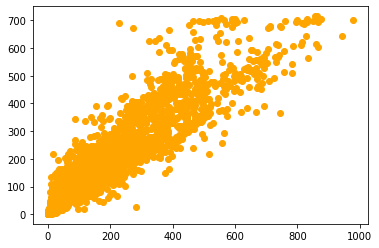

In [190]:
# fit the model to the training subset of original training data
model.fit(train_set_x[cols], train_set_x['count'])

# predict on the testing subset of the original training data
pred_count = model.predict(test_set_x[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(test_set_x['count'],pred_count))
print("RMS error:",rms)
plt.scatter(test_set_y,pred_count,color='orange')
plt.show

RMS error: 18.100454018510856


<function matplotlib.pyplot.show>

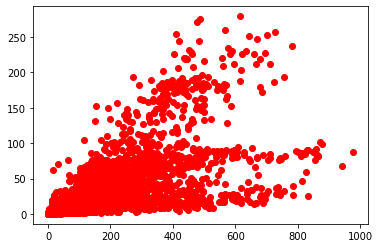

In [183]:
# fit the model to the training subset of original training data for casual vehicles
model.fit(train_set_x[cols], train_set_x['casual'])

# predict on the testing subset of the original casual vehicles
pred_casual = model.predict(test_set_x[cols])

# score the model on the new test set
rms = np.sqrt(mean_squared_error(test_set_x['casual'],pred_casual))
print("RMS error:",rms)
plt.scatter(test_set_y,pred_casual,color='red')
plt.show

RMS error: 60.44862209068791


<function matplotlib.pyplot.show>

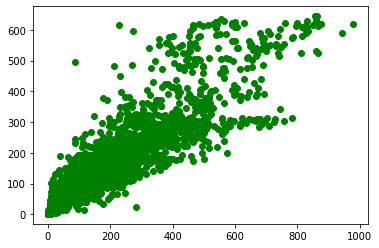

In [184]:
#Fit the model to a portion of the training set, test on the rest and evaluate
# fit the model to the training subset of original training data
model.fit(train_set_x[cols], train_set_x['registered'])

# predict on the testing subset of the original for registered vehicles
pred_registered = model.predict(test_set_x[cols])

# score the model on the new test set
rms = np.sqrt(mean_squared_error(test_set_x['registered'],pred_registered))
print("RMS error:",rms)
plt.scatter(test_set_y,pred_registered,color='green')
plt.show

In [194]:
test_df = pd.read_csv('https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/datasets/lab_assignment_06/test_luc.csv', sep=",")
print("\nNumber of samples:",test_df.shape[0] ,"and number of features:",test_df.shape[1],"\n")

# must add that new feature into the test data too, to use it in prediction
test_df['hour'] = test_df['datetime'].map(hour_of_day)
test_df['month'] = test_df['datetime'].map(hour_of_day)
# show the test data output to be sure it read in correctly and added the column
test_df.head()




Number of samples: 1712 and number of features: 9 



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month
0,2011-01-17 00:00:00,1,1,0,2,8.20,9.850,47,15.0013,0,0
1,2011-01-17 01:00:00,1,1,0,2,8.20,9.850,44,12.9980,1,1
2,2011-01-17 02:00:00,1,1,0,2,7.38,8.335,43,16.9979,2,2
3,2011-01-17 03:00:00,1,1,0,2,7.38,9.090,43,12.9980,3,3
4,2011-01-17 04:00:00,1,1,0,2,7.38,9.850,43,8.9981,4,4


In [195]:
# fit the selected model TO YOUR FULL TRAINING SET
model.fit( bike_df[cols], bike_df['count'])
pred_count = model.predict(test_df[cols])
model.fit( bike_df[cols], bike_df['casual'])
pred_casual = model.predict(test_df[cols])
model.fit( bike_df[cols], bike_df['registered'])
pred_registered = model.predict(test_df[cols])

# apply to the test data FOR WHICH YOU DON'T HAVE THE ANSWERS
# (not the "test set" you used for model selection and tuning) 
# add the prediction column (in case you want to inspect it later)
test_df['count'] = pred_count
test_df['casual'] = pred_casual
test_df['registered'] = pred_registered
test_df['sum of casual and registered'] = pred_casual+pred_registered

sample_df = pd.read_csv('https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/datasets/lab_assignment_06/sample_prediction.csv', sep=",")

#comparing with the sample data 
print("count of sum of casual and registered data RMS error of sample data:",np.sqrt(mean_squared_error(sample_df['count'],pred_casual+pred_registered)))
print("count RMS error of sample data:",np.sqrt(mean_squared_error(sample_df['count'],pred_count)))

# save the predicted count as a csv with a header column and datetime row
test_df = test_df[['datetime','count','casual','registered','sum of casual and registered']].to_csv('my_prediction.csv',    index=False, header=True)
print("Prediction complete. Saved as my_prediction.csv")

count of sum of casual and registered data RMS error of sample data: 96.3373823784906
count RMS error of sample data: 92.89096150455866
Prediction complete. Saved as my_prediction.csv
